In [47]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [48]:
import pickle
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scikeras.wrappers import KerasClassifier
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Version information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Keras version:", tf.keras.__version__)

Num GPUs Available:  0
NumPy version: 1.24.3
Pandas version: 2.0.3
Matplotlib version: 3.7.2
Keras version: 2.10.0


In [81]:
# Data loading, pre-processing, and exploration

# Load the dataset
with open('data/emnist_train.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('data/emnist_test.pkl', 'rb') as f:
    test_data = pickle.load(f)

X_train = train_data['data']
y_train = train_data['labels']

X_test = test_data['data']
y_test = test_data['labels']

In [83]:
# Reshape the data
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Normalize the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
num_classes = 62
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [85]:
# Create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("\nAfter creating validation set:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


After creating validation set:
X_train shape: (80000, 28, 28, 1)
y_train shape: (80000, 62)
X_val shape: (20000, 28, 28, 1)
y_val shape: (20000, 62)
X_test shape: (20000, 28, 28, 1)
y_test shape: (20000, 62)


In [100]:
# Design RNN Model
def create_rnn_model(learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(28, 28)))
    # LSTM
    model.add(LSTM(128, return_sequences=False))
    model.add(BatchNormalization())
    # Dropout
    model.add(Dropout(0.5))
    # Dense
    model.add(Dense(128, activation='relu'))
    # Dropout
    model.add(Dropout(0.5))
    # Output
    model.add(Dense(62, activation='softmax'))
    # Compile
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
rnn_model = KerasClassifier(model=create_rnn_model, verbose=0)
param_grid_rnn = {
    'batch_size': [64, 128],
    'epochs': [5],
    'model__learning_rate': [0.001, 0.0001],
}
grid_search_rnn = GridSearchCV(estimator=rnn_model, param_grid=param_grid_rnn, cv=3, verbose=2, n_jobs=1)
grid_result_rnn = grid_search_rnn.fit(X_train, y_train)
print(f"best params: {grid_result_rnn.best_params_}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=64, epochs=5, model__learning_rate=0.001; total time= 3.7min
[CV] END batch_size=64, epochs=5, model__learning_rate=0.001; total time= 3.7min
[CV] END batch_size=64, epochs=5, model__learning_rate=0.001; total time= 3.7min
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0001; total time= 3.7min
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0001; total time= 3.8min
[CV] END batch_size=64, epochs=5, model__learning_rate=0.0001; total time= 3.7min
[CV] END batch_size=128, epochs=5, model__learning_rate=0.001; total time= 2.8min
[CV] END batch_size=128, epochs=5, model__learning_rate=0.001; total time= 2.7min
[CV] END batch_size=128, epochs=5, model__learning_rate=0.001; total time= 2.8min
[CV] END batch_size=128, epochs=5, model__learning_rate=0.0001; total time= 2.8min
[CV] END batch_size=128, epochs=5, model__learning_rate=0.0001; total time= 2.8min
[CV] END batch_size=128, epochs=5, mode

In [101]:
# best_params_rnn = grid_result_rnn.best_params_
best_params_rnn = {'batch_size': 64, 'epochs': 10, 'model__learning_rate': 0.001}
best_rnn = create_rnn_model(learning_rate=best_params_rnn['model__learning_rate'])
best_rnn.summary()
history_rnn = best_rnn.fit(X_train, y_train,
                          validation_data=(X_val, y_val),
                          epochs=best_params_rnn['epochs'],
                          batch_size=best_params_rnn['batch_size'])

Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_131 (LSTM)             (None, 128)               80384     
                                                                 
 batch_normalization_131 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_89 (Dropout)        (None, 128)               0         
                                                                 
 dense_171 (Dense)           (None, 128)               16512     
                                                                 
 dropout_90 (Dropout)        (None, 128)               0         
                                                                 
 dense_172 (Dense)           (None, 62)                7998      
                                                    

In [102]:
# Evaluating the RNN model on test data

# Predict classes
y_pred_rnn = best_rnn.predict(X_test)
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy_rnn = accuracy_score(y_test_classes, y_pred_rnn_classes)
print(f"RNN Test Accuracy: {accuracy_rnn:.4f}")

625/625 [==============================] - 11s 16ms/step
RNN Test Accuracy: 0.8307


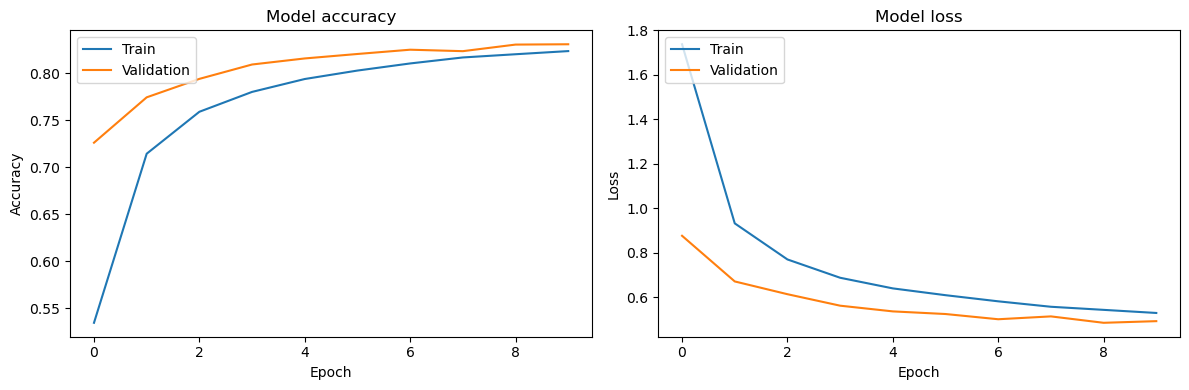

In [106]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()